### Content Analysis
#### Joseph Denby

Load relevant packages and functions. 

In [2]:
import pandas as pd
import numpy as np
import random
import feather

import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy
import lucem_illud

import nltk
from nltk.tokenize import RegexpTokenizer

import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns
%matplotlib inline

In [3]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pd.DataFrame(countsForFrame)

In [119]:
def wordsample(tokens, n):
    '''
    takes a list of tokens and an amount of words and returns a random word sample
    
    Inputs:
        tokens - list of tokenized text
        n - int
    
    Outputs:
        sample - contiguous n-word sample from tokens
    '''
    
    if len(tokens) <= n:
        sample = tokens
    else:
        startindex = random.randint(1, len(tokens)-n)
        sample = tokens[startindex : startindex+n]
    
    return sample

In [72]:
def POSdict(tokens_POS):
    '''
    takes a list of tuples indicating POS taggings for tokenized words and returns 
    a dictionary counting up the POS tag instances
    
    Inputs:
        tokens_POS - list of tuples
        
    Outputs:
        POSdict - dictionary
    '''
    POSdict = {}
    for t in tokens_POS:
        word, tag = t
        if tag not in ['.', ',', "''", '#', '?', '!', ':', '(', ')', '$', '"', '``']:
            if tag not in POSdict:
                POSdict[tag] = 0
            POSdict[tag] += 1
    
    return POSdict

In [38]:
def getavgPOSdict(POSdictseries):
    '''
    takes a series of POSdicts and returns a dictionary with the average POS counts 
    
    Inputs:
        POSdictseries - series of POSdicts
        
    Outputs:
        avgPOSdict - dictionary
    '''
    
    avgPOSdict = {}
    total = len(POSdictseries)
    
    for d in POSdictseries:
        for k, v in d.items():
            if k not in avgPOSdict:
                avgPOSdict[k] = 0
            avgPOSdict[k] += v/total
    
    return avgPOSdict
    

In [120]:
def averageSampleCounts(dataframe, n):
    '''
    Takes a DataFrame and returns a dictionary
    with the counts for each POS found in a random contiguous n word sample.
    
    Inputs:
        dataframe - DataFrame
    
    Outputs:
        avgPOSdict - dictionary 
    
    '''
    tag = str(n) + 'wordsample'
    
    dataframe[tag] = dataframe['tokens'].apply(lambda x: wordsample(x, n))
    dataframe['tokens_POS'] = [nltk.pos_tag(t) for t in dataframe[tag]]
    
    dataframe['POSdict'] = dataframe['tokens_POS'].apply(lambda x: POSdict(x))
    avgPOSdict = getavgPOSdict(dataframe['POSdict'])
    
    return avgPOSdict
    
    

In [197]:
def getPOSdf(chatavgavgPOSdict, bookavgavgPOSdict):
    '''
    Takes two dictionaries with the average average POS counts and converts them into a single melted DataFrame,
    primed for plotting.
    
    Inputs:
        chatavgavgPOSdict - dictionary
        bookavgavgPOSdict - dictionary
    Output:
        compareavgPOSdf - DataFrame
    '''
    
    chatavgPOSdf = pd.DataFrame.from_dict(chatavgavgPOSdict, orient = 'index')
    bookavgPOSdf = pd.DataFrame.from_dict(bookavgavgPOSdict, orient = 'index')
    
    chatavgPOSdf = chatavgPOSdf.reset_index()
    bookavgPOSdf = bookavgPOSdf.reset_index()
    
    chatavgPOSdf = chatavgPOSdf.rename(columns = {'index': 'POS', 0: 'chat'})
    bookavgPOSdf = bookavgPOSdf.rename(columns = {'index': 'POS', 0: 'book'})
    
    compareavgPOSdf = bookavgPOSdf.merge(chatavgPOSdf, how='left', on='POS',)
    compareavgPOSdf['abs_diff'] = compareavgPOSdf.apply(lambda x: x['book'] - x['chat'], axis=1)
    compareavgPOSdf = compareavgPOSdf.sort_values('abs_diff', ascending=False)
    compareavgPOSdf = compareavgPOSdf.reset_index(drop=True)
    compareavgPOSdf = compareavgPOSdf.melt(id_vars=['POS'], value_vars=['book', 'chat'], var_name='source', value_name='avgcount')
    
    return compareavgPOSdf

In [157]:
def getPOSsterrs(avgPOSdicts):
    POSsterrs = {}
    for d in avgPOSdicts:
        for k, v in d.items():
            if k not in POSsterrs:
                POSsterrs[k] = []
            POSsterrs[k].append(v)
                    
    for k, v in POSsterrs.items():
        POSsterrs[k] = np.array(v)
        POSsterrs[k] = np.std(v)/np.sqrt(len(POSsterrs[k]))
    return POSsterrs

Read in dataframes

In [12]:
ldpdf = pd.read_csv('ldpdf.csv', index_col=0)

In [52]:
ldpdf['tokens'] = ldpdf.p_chat.apply(lambda x: nltk.wordpunct_tokenize(x))
ldpdf['word_count'] = ldpdf.tokens.apply(lambda x: len(x))

In [126]:
#set word sample size
n = 150

In [122]:
chatavgPOSdicts = []
for i in range(100):
    if i % 10 == 0:
        print(i)
    dict = averageSampleCounts(ldpdf, n)
    chatavgPOSdicts.append(dict)

chatavgavgPOSdict = getavgPOSdict(chatavgPOSdicts)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [137]:
chatavgPOSdicts

[{'CC': 1.8240534521157987,
  'CD': 1.0868596881959882,
  'DT': 8.633630289532194,
  'EX': 0.5089086859688181,
  'FW': 0.0289532293986637,
  'IN': 8.0389755011135,
  'JJ': 7.1726057906457985,
  'JJR': 0.2861915367483296,
  'JJS': 0.01893095768374164,
  'MD': 1.5167037861915276,
  'NN': 19.391982182627974,
  'NNP': 5.200445434298396,
  'NNPS': 0.012249443207126948,
  'NNS': 2.620267260579043,
  'PDT': 0.12806236080178163,
  'POS': 0.4877505567928714,
  'PRP': 14.768374164810517,
  'PRP$': 2.015590200445422,
  'RB': 6.459910913140244,
  'RBR': 0.11692650334075706,
  'RBS': 0.0066815144766146995,
  'RP': 1.1703786191536687,
  'TO': 3.05233853006679,
  'UH': 1.3195991091313968,
  'VB': 11.160356347438627,
  'VBD': 2.489977728285058,
  'VBG': 2.2861915367483117,
  'VBN': 0.6169265033407552,
  'VBP': 6.277282850779441,
  'VBZ': 2.775055679287283,
  'WDT': 0.2928730512249442,
  'WP': 2.0233853006681386,
  'WP$': 0.02561247216035635,
  'WRB': 1.168151447661464},
 {'CC': 1.857461024498872,
  'C

In [152]:
chatPOSsterrs = {}
for d in chatavgPOSdicts:
    for k, v in d.items():
        if k not in chatPOSsterrs:
            chatPOSsterrs[k] = []
        chatPOSsterrs[k].append(v)
for k, v in chatPOSsterrs.items():
    chatPOSsterrs[k] = np.array(v)
    chatPOSsterrs[k] = np.std(v)/np.sqrt(len(chatPOSsterrs[k]))

In [158]:
chatPOSsterrs = getPOSsterrs(chatavgPOSdicts)

In [123]:
chatavgavgPOSdict = getavgPOSdict(chatavgPOSdicts)

In [124]:
bookdf = pd.read_csv("bookdf.csv", index_col=0)

## 
bookdf = bookdf.drop(15) #to get rid of 'Goodnight Moon' which has less than 100 words
bookdf = bookdf.reset_index(drop=True)
##

bookdf['tokens'] = bookdf['text'].apply(lambda x: nltk.wordpunct_tokenize(x))
#bookdf['nltktext'] = bookdf['tokens'].apply(lambda x: nltk.Text(x))
bookdf['word_count'] = bookdf.tokens.apply(lambda x: len(x))
#bookdf['wordsample100'] = bookdf.tokens.apply(lambda x: wordsample100(x))

In [127]:
bookavgPOSdicts = []
for i in range(100):
    if i % 10 == 0:
        print (i)
    dict = averageSampleCounts(bookdf, n)
    bookavgPOSdicts.append(dict)

bookavgavgPOSdict = getavgPOSdict(bookavgPOSdicts)

0
10
20
30
40
50
60
70
80
90


In [198]:
compareavgPOSdf = getPOSdf(chatavgavgPOSdict, bookavgavgPOSdict)

In [199]:
compareavgPOSdf.head()

,POS,source,avgcount
0,NNP,book,12.818586
1,VBD,book,9.576162
2,CC,book,5.320606
3,DT,book,11.524242
4,IN,book,10.136768


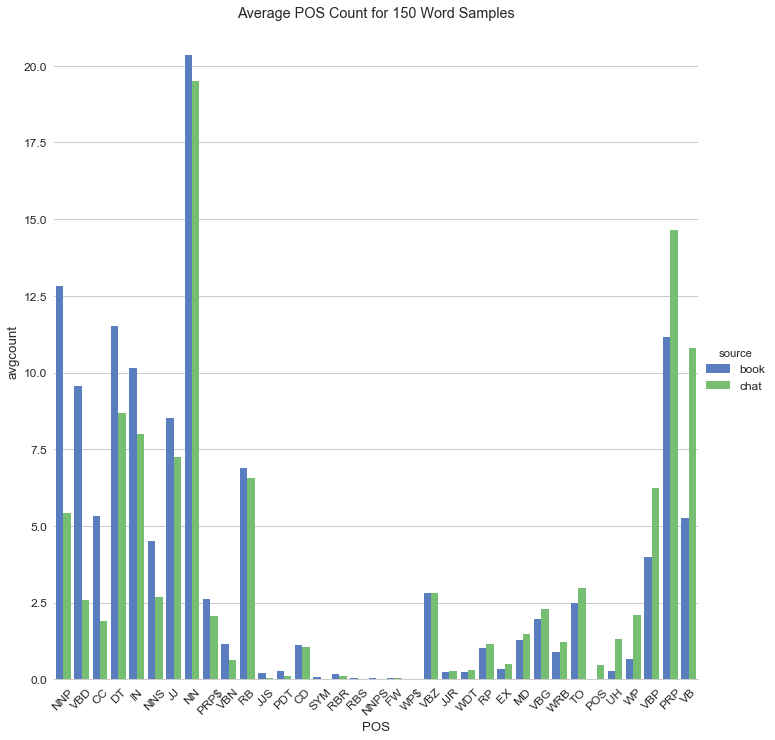

In [200]:
sns.set(font_scale=1.2, style='whitegrid')

g = sns.factorplot(x = 'POS', y = 'avgcount', hue='source', data=compareavgPOSdf, size=10, kind='bar', palette='muted')
g.despine(left = True)
g.set_xticklabels(rotation=45)
axes = g.axes.flatten()
axes[0].set_title('Average POS Count for ' + str(n) + ' Word Samples')

g.savefig('avgPOS150.pdf')

`NNP` = Proper Noun; `VBP` = Verb 'to be', singular present non 3rd (e.g, 'am', 'are'); `DT` = Determiner (e.g., 'a', 'the', 'every'); `VBD` = Verb 'to be', past tense; `IN`= preposition, subordinating conjunction; `CC` = coordination conjunction (e.g., 'and'); `PRP` = Personal Pronoun (e.g., 'I', 'she', 'you', 'it'); `VB` = verb 'to be', base form (i.e., 'be'); `NNS` = plural nouns; `WP` = verb, sing. present non 3rd (e.g., 'take', 'play')

- Organize by difference between counts. [DONE]
- Look at change over time (based on session or suggested grade/age level for books)
- Try parsing - look at tree depth over book sentences.

Compute stopword list based on corpus frequency and create tokenized and normalized nltk sentence columns.

In [5]:
alltokens = bookdf['tokens'].sum()

#all words sorted by frequency
allcountedWords = wordCounter(alltokens)
allcountedWords.sort_values('count', ascending=False, inplace=True)

stop_words_freq = []
countsDict = {}
for word in alltokens:
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:100]
for word, count in word_counts:
    if word == 'little':
        break
    else:
        stop_words_freq.append(word)

In [7]:
bookdf['tokenized_sents'] = bookdf['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
bookdf['normalized_sents'] = bookdf['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = stop_words_freq, stemmer = None) for s in x])
bookdf[:5]

,author,text,title,tokens,nltktext,tokenized_sents,normalized_sents
0,Jules Feiffer,"George’s mother said: ""Bark, George."" George w...","Bark, George","[George, ’, s, mother, said, :, ``, Bark, ,, G...","(George, ’, s, mother, said, :, ``, Bark, ,, G...","[[George, ’, s, mother, said, :, ``, Bark, ,, ...","[[george, mother, bark, george], [george, went..."
1,Robert McCloskey,"One day, Little Sal went with her mother to Bl...",Blueberries for Sal,"[One, day, ,, Little, Sal, went, with, her, mo...","(One, day, ,, Little, Sal, went, with, her, mo...","[[One, day, ,, Little, Sal, went, with, her, m...","[[one, day, little, sal, went, mother, blueber..."
2,Bill Martin Jr,"Brown Bear, Brown Bear, What do you see? I see...","Brown Bear, Brown Bear, What Do You See?","[Brown, Bear, ,, Brown, Bear, ,, What, do, you...","(Brown, Bear, ,, Brown, Bear, ,, What, do, you...","[[Brown, Bear, ,, Brown, Bear, ,, What, do, yo...","[[brown, bear, brown, bear, what, do, see], [i..."
3,Doreen Cronin,Farmer Brown has a problem. His cows like to t...,"Click, Clack, Moo Cows that Type","[Farmer, Brown, has, a, problem, ., His, cows,...","(Farmer, Brown, has, a, problem, ., His, cows,...","[[Farmer, Brown, has, a, problem, .], [His, co...","[[farmer, brown, has, problem], [cows, type], ..."
4,Judi Barrett,We were all sitting around the big kitchen tab...,Cloudy With a Chance of Meatballs,"[We, were, all, sitting, around, the, big, kit...","(We, were, all, sitting, around, the, big, kit...","[[We, were, all, sitting, around, the, big, ki...","[[we, were, sitting, around, big, kitchen, tab..."


Now, create a tf-idf matrix. This is a sparse matrix with each row being a document (book) and each column a word appearing in the corpus.

First, a vectorizer that creates a count matrix (each field is the number of times a word appears in a document).

In [117]:
#First it needs to be initialized
bookCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
bookgroupVects = bookCountVectorizer.fit_transform(bookdf['text'])

In [16]:
bookgroupVects.shape

(100, 5577)

In [49]:
bookCountVectorizer.vocabulary_.get("")

Now, compute the tf-idf matrix. This assigns a score (tf-idf) to each word in each document according to its 'tellingness.' Each score is an indication of the word's importance within a document weighted by its relative presence across the entire corpus.

In [57]:

#initialize
bookTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stop_words_freq, norm='l2')
#train
bookgroupTFVects = bookTFVectorizer.fit_transform(bookdf['text'])

In [62]:
list(zip(bookTFVectorizer.vocabulary_.keys(), bookgroupTFVects.data))[:20]

[('george', 0.8250452029628907),
 ('mother', 0.0806859374239559),
 ('bark', 0.30346153103359197),
 ('went', 0.10025854047243683),
 ('meow', 0.07409044053577216),
 ('no', 0.02782304744964275),
 ('cats', 0.023572720084654025),
 ('go', 0.053296564657065615),
 ('dogs', 0.06539709675813102),
 ('arf', 0.12138461241343679),
 ('now', 0.02875583332681148),
 ('quack', 0.1481808810715443),
 ('ducks', 0.02607259267803477),
 ('oink', 0.07821777803410432),
 ('pigs', 0.02607259267803477),
 ('moo', 0.055692561019956906),
 ('took', 0.013447656237325984),
 ('vet', 0.2124230717235144),
 ('ll', 0.011014437746450794),
 ('soon', 0.014532100367612747)]

In [123]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 4).fit(bookgroupTFVects.toarray())
reduced_data = pca.transform(bookgroupTFVects.toarray())
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
booktitles = bookdf['title']
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

In [122]:
redu

array([[-6.92441597e-04, -3.10051955e-04, -1.73959139e-03, ...,
        -3.74375126e-04, -1.84840795e-03, -8.40431720e-05],
       [ 6.11263516e-04,  1.76518196e-04, -5.11822857e-04, ...,
        -5.01952367e-04,  3.72336919e-03, -1.87272269e-04]])

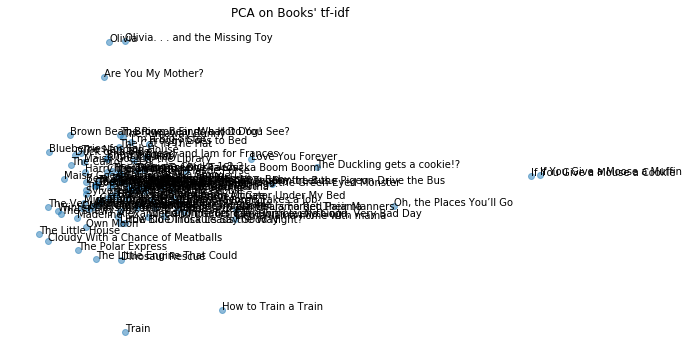

In [127]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 2], reduced_data[:, 3], alpha = 0.5)
for i, booktitle in enumerate(booktitles):
    ax.annotate(booktitle, (reduced_data[i,2], reduced_data[i,3]))
plt.xticks(())
plt.yticks(())
plt.title('PCA on Books\' tf-idf')
plt.show()

Based on above filtering, most books have similar tf-idf vectors except for a few. Upon closer inspection, these books appear to use idiosyncratic words frequently (e.g., George, Llama). I can try adding these to the stop words list to see how this changes the PCA.

In [96]:
new_stop_words = stop_words_freq[:] + ['george', 'llama']
#initialize
newbookTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=.5, min_df=3, stop_words=new_stop_words, norm='l2')
#train
newbookgroupTFVects = newbookTFVectorizer.fit_transform(bookdf['text'])

In general – can tweak a few parameters w.r.t. tfidfvectorizer: max_df, min_df, stop_words.
Could also experiment with different stemming / lemmatization pre-processing.

In [129]:
newpca = PCA(n_components = 10).fit(newbookgroupTFVects.toarray())
newreduced_data = newpca.transform(newbookgroupTFVects.toarray())
components = newpca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
booktitles = bookdf['title']
#words = [terms[i] for i in keyword_ids]#Turn the ids into words.
#x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
#y = components[:,keyword_ids][1,:]

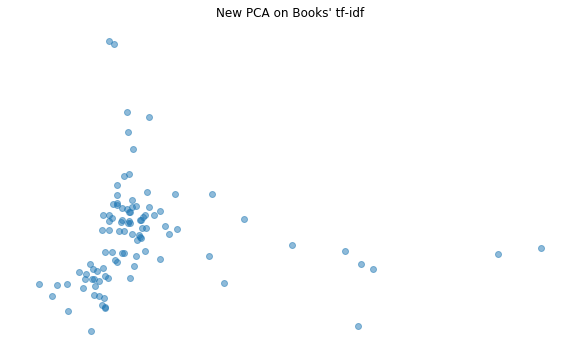

In [103]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(newreduced_data[:, 0], newreduced_data[:, 1], alpha = 0.5)
#for i, booktitle in enumerate(booktitles):
 #   ax.annotate(booktitle, (newreduced_data[i,0], newreduced_data[i,1]))
plt.xticks(())
plt.yticks(())
plt.title('New PCA on Books\' tf-idf')
plt.show()

Clustering algorithm:

In [111]:
numCategories = 3

In [112]:
bookKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
bookKM.fit(newbookgroupTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

This allows us to visualize the top 10 words per cluster:

In [128]:
terms = bookTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = bookKM.cluster_centers_.argsort()[:, ::-1]
for i in range(numCategories):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 any
 eve
 along
 babushka
 become
 already
 across
 arrangement
 battered
 dearest


Cluster 1:
 elves
 due
 bumps
 claimed
 backward
 enters
 businesses
 dragon
 approached
 examine


Cluster 2:
 chopping
 choking
 ceilings
 charlie
 battered
 bumps
 bathtub
 counter
 expecting
 chops




Here we can reduce the tf-idf matrix using PCA in order to make visualization easier.

In [114]:
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in bookKM.labels_]

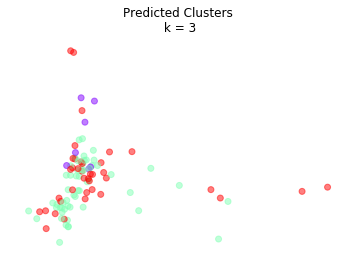

In [115]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(newreduced_data[:, 0], newreduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()